# Classification using Logistic Regression

We are using the logistic regression algorithm to predict a person is diabetic or not based on the health data

To add PySpark to sys.path for running the code on the Jupyter IDE we are Using the package findspark

In [1]:
import pyspark
import findspark
findspark.init()
findspark.find()

'C:\\Spark\\spark-3.0.3-bin-hadoop2.7'

To perform any task on spark you need start a spark session, here we are starting a session for our logistic regression

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Logistic App").getOrCreate()

To start, we are loading the diabetes dataset 

In [3]:
!wget https://raw.githubusercontent.com/ismayilsiyad/hpe_ml/main/diabetes.csv
diabetes = spark.read.csv('diabetes.csv',header= True)
diabetes.printSchema()
diabetes.show()

--2022-01-10 22:18:01--  https://raw.githubusercontent.com/ismayilsiyad/hpe_ml/main/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 776415 (758K) [text/plain]
Saving to: 'diabetes.csv.13'

     0K .......... .......... .......... .......... ..........  6% 1.47M 0s
    50K .......... .......... .......... .......... .......... 13% 2.59M 0s
   100K .......... .......... .......... .......... .......... 19% 1.10M 0s
   150K .......... .......... .......... .......... .......... 26% 63.2M 0s
   200K .......... .......... .......... .......... .......... 32%  974K 0s
   250K .......... .......... .......... .......... .......... 39% 8.09M 0s
   300K .......... .......... .......... .......... .......... 46% 6.80M 0s
   350K .......... .......... ....

root
 |-- PatientID: string (nullable = true)
 |-- Pregnancies: string (nullable = true)
 |-- PlasmaGlucose: string (nullable = true)
 |-- DiastolicBloodPressure: string (nullable = true)
 |-- TricepsThickness: string (nullable = true)
 |-- SerumInsulin: string (nullable = true)
 |-- BMI: string (nullable = true)
 |-- DiabetesPedigree: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Diabetic: string (nullable = true)

+---------+-----------+-------------+----------------------+----------------+------------+-----------+----------------+---+--------+
|PatientID|Pregnancies|PlasmaGlucose|DiastolicBloodPressure|TricepsThickness|SerumInsulin|        BMI|DiabetesPedigree|Age|Diabetic|
+---------+-----------+-------------+----------------------+----------------+------------+-----------+----------------+---+--------+
|  1354778|          0|          171|                    80|              34|          23|43.50972593|     1.213191354| 21|       0|
|  1147438|          8|      

# Dropping unwanted columns

We need to drop unwanted columns from the dataset. By looking into the dataset we can see columns 'PatientID' have no relevance in predicting the diabetes. To have this insight in a complex problem. we have to formulate the hypothesis and evaluation of the hypothesis should be done.

In [4]:
colm = 'PatientID'
db_df = diabetes.select([column for column in diabetes.columns if column not in colm])
db_df.printSchema()

root
 |-- Pregnancies: string (nullable = true)
 |-- PlasmaGlucose: string (nullable = true)
 |-- DiastolicBloodPressure: string (nullable = true)
 |-- TricepsThickness: string (nullable = true)
 |-- SerumInsulin: string (nullable = true)
 |-- BMI: string (nullable = true)
 |-- DiabetesPedigree: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Diabetic: string (nullable = true)



# Changing the column datatype

We need to change column datatype to float from the initial string datatype

In [5]:
from pyspark.sql.functions import col
db_df = db_df.select(*(col(c).cast('float').alias(c) for c in db_df.columns))
db_df.printSchema()

root
 |-- Pregnancies: float (nullable = true)
 |-- PlasmaGlucose: float (nullable = true)
 |-- DiastolicBloodPressure: float (nullable = true)
 |-- TricepsThickness: float (nullable = true)
 |-- SerumInsulin: float (nullable = true)
 |-- BMI: float (nullable = true)
 |-- DiabetesPedigree: float (nullable = true)
 |-- Age: float (nullable = true)
 |-- Diabetic: float (nullable = true)



# Taking the count of the null and missing values

In [6]:
from pyspark.sql.functions import col, count, isnan, when
db_df.select([count(when(col(c).isNull(), c)).alias(c) for c in db_df.columns]).show()

+-----------+-------------+----------------------+----------------+------------+---+----------------+---+--------+
|Pregnancies|PlasmaGlucose|DiastolicBloodPressure|TricepsThickness|SerumInsulin|BMI|DiabetesPedigree|Age|Diabetic|
+-----------+-------------+----------------------+----------------+------------+---+----------------+---+--------+
|          0|            0|                     0|               0|           0|  0|               0|  0|       0|
+-----------+-------------+----------------------+----------------+------------+---+----------------+---+--------+



# List of columns to vector form

We are using VectorAssembler to convert the list columns in our dataset to vector form in which all the features are grouped to vector form

In [7]:
features = db_df.drop('Diabetic')
from pyspark.ml.feature import VectorAssembler
#let's assemble our features together using vectorAssembler
assembler = VectorAssembler(
    inputCols=features.columns,
    outputCol="features")
output = assembler.transform(db_df).select('features','Diabetic')

# Splitting the data into training and testing datasets

The dataset in vector form is now splitting into train and test datset fractions


In [8]:
train,test = output.randomSplit([0.75, 0.25])
train.show()
test.show()

+--------------------+--------+
|            features|Diabetic|
+--------------------+--------+
|[0.0,44.0,44.0,26...|     0.0|
|[0.0,44.0,79.0,27...|     0.0|
|[0.0,44.0,100.0,4...|     0.0|
|[0.0,45.0,51.0,10...|     0.0|
|[0.0,45.0,57.0,51...|     0.0|
|[0.0,45.0,60.0,31...|     0.0|
|[0.0,45.0,63.0,8....|     0.0|
|[0.0,45.0,65.0,46...|     0.0|
|[0.0,45.0,90.0,25...|     0.0|
|[0.0,45.0,90.0,40...|     0.0|
|[0.0,45.0,90.0,41...|     0.0|
|[0.0,45.0,91.0,10...|     0.0|
|[0.0,46.0,55.0,21...|     0.0|
|[0.0,46.0,55.0,33...|     0.0|
|[0.0,46.0,61.0,46...|     0.0|
|[0.0,46.0,66.0,44...|     0.0|
|[0.0,46.0,89.0,7....|     0.0|
|[0.0,47.0,51.0,44...|     0.0|
|[0.0,47.0,53.0,40...|     0.0|
|[0.0,47.0,77.0,35...|     1.0|
+--------------------+--------+
only showing top 20 rows

+--------------------+--------+
|            features|Diabetic|
+--------------------+--------+
|[0.0,45.0,54.0,44...|     0.0|
|[0.0,45.0,87.0,7....|     0.0|
|[0.0,46.0,42.0,8....|     0.0|
|[0.0,46.0,45.

# Train the Logistic Regression Model

We are using Logistic Regression model for classsification problem. In the following step we training the logistic regression model with labels and features. This kind of training where both labels and features are used are known as supervised learning

In [9]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Diabetic', maxIter=10)
lrModel = lr.fit(train)

# Coefficients of the Model

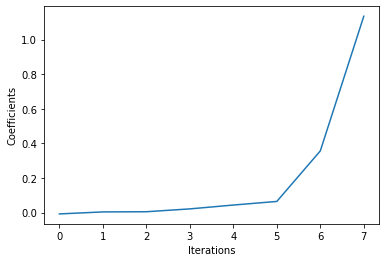

In [10]:
import matplotlib.pyplot as plt
import numpy as np
coeff = np.sort(lrModel.coefficients)
plt.plot(coeff)
plt.ylabel('Coefficients')
plt.xlabel('Iterations')
plt.show()

# Predictions and labels

To compare the predictions with actual labels we use model.transform

In [11]:
predictions = lrModel.transform(test)
predictions.show(10)
predictions = predictions.withColumnRenamed("Diabetic","label")
predictions.show(10)

+--------------------+--------+--------------------+--------------------+----------+
|            features|Diabetic|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|[0.0,45.0,54.0,44...|     0.0|[2.64077486874980...|[0.93344012292881...|       0.0|
|[0.0,45.0,87.0,7....|     0.0|[3.62265116868218...|[0.97398318978416...|       0.0|
|[0.0,46.0,42.0,8....|     0.0|[-0.6226735339615...|[0.34917364233365...|       1.0|
|[0.0,46.0,45.0,27...|     0.0|[4.11386105626310...|[0.98391830270050...|       0.0|
|[0.0,47.0,53.0,45...|     0.0|[2.06619624504099...|[0.88757395752308...|       0.0|
|[0.0,48.0,49.0,8....|     0.0|[2.60355991874725...|[0.93109033885261...|       0.0|
|[0.0,48.0,85.0,40...|     0.0|[2.46924061864933...|[0.92195714323998...|       0.0|
|[0.0,48.0,95.0,7....|     0.0|[3.82053441246183...|[0.97855392840457...|       0.0|
|[0.0,49.0,84.0,8....|     0.0|[3.69163064810642...|[0.9756751361

# Confusion matrix

In [12]:
import sklearn

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import   confusion_matrix
from sklearn import metrics
#print(classification_report(y_true, y_pred))
print("Confusion Matrix", confusion_matrix(y_true, y_pred))

Confusion Matrix [[2177  337]
 [ 531  727]]


# Accuracy, Precision, Recall, F1-Score 

In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
evaluator = BinaryClassificationEvaluator()
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
#print('Area Under ROC', evaluator.evaluate(predictions))


# Get metrics
acc = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "weightedRecall"})
#auc = evaluator.evaluate(predictionAndTarget)

print('Precision', weightedPrecision)
print('Accuracy', acc)
print('F1-Score', f1)
print('Recall', weightedRecall)


Precision 0.7636784548415279
Accuracy 0.7698833510074231
F1-Score 0.7645448578502336
Recall 0.7698833510074231


# Area Under ROC
ROC Curve is plotting using model.summary and AUC 

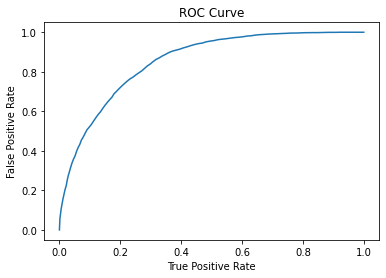

Area UnderROC: 0.8527041319816946


In [14]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Area UnderROC: ' + str(trainingSummary.areaUnderROC))

# Train the Decision Tree Classification Model

We are using Decision Tree model for classsification problem. In the following step we training the decision tree model with labels and features. This kind of training where both labels and features are used are known as supervised learning

In [29]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="Diabetic", featuresCol="features", maxDepth = 3)
dtModel = dt.fit(train)
predictions_dt = dtModel.transform(test)
predictions_dt.show(10)

+--------------------+--------+--------------+--------------------+----------+
|            features|Diabetic| rawPrediction|         probability|prediction|
+--------------------+--------+--------------+--------------------+----------+
|[0.0,45.0,54.0,44...|     0.0|[5208.0,208.0]|[0.96159527326440...|       0.0|
|[0.0,45.0,87.0,7....|     0.0|[5208.0,208.0]|[0.96159527326440...|       0.0|
|[0.0,46.0,42.0,8....|     0.0|[5208.0,208.0]|[0.96159527326440...|       0.0|
|[0.0,46.0,45.0,27...|     0.0|[5208.0,208.0]|[0.96159527326440...|       0.0|
|[0.0,47.0,53.0,45...|     0.0|[5208.0,208.0]|[0.96159527326440...|       0.0|
|[0.0,48.0,49.0,8....|     0.0|[5208.0,208.0]|[0.96159527326440...|       0.0|
|[0.0,48.0,85.0,40...|     0.0|[5208.0,208.0]|[0.96159527326440...|       0.0|
|[0.0,48.0,95.0,7....|     0.0|[5208.0,208.0]|[0.96159527326440...|       0.0|
|[0.0,49.0,84.0,8....|     0.0|[5208.0,208.0]|[0.96159527326440...|       0.0|
|[0.0,49.0,86.0,7....|     0.0|[5208.0,208.0]|[0.961

# Accuracy, Precision, Recall, and F1-Score of Decision Tree Model

In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
evaluator = BinaryClassificationEvaluator()
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Diabetic", predictionCol="prediction")
#print('Area Under ROC', evaluator.evaluate(predictions))


# Get metrics
acc = evaluatorMulti.evaluate(predictions_dt, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictions_dt, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictions_dt, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictions_dt, {evaluatorMulti.metricName: "weightedRecall"})
#auc = evaluator.evaluate(predictionAndTarget)

print('Precision', weightedPrecision)
print('Accuracy', acc)
print('F1-Score', f1)
print('Recall', weightedRecall)


Precision 0.8651540313977562
Accuracy 0.8666489925768823
F1-Score 0.865363636667133
Recall 0.8666489925768822


# Confusion Matrix of Decision Tree Model 

In [31]:
import sklearn

y_true = predictions_dt.select(['Diabetic']).collect()
y_pred = predictions_dt.select(['prediction']).collect()

from sklearn.metrics import   confusion_matrix
from sklearn import metrics
#print(classification_report(y_true, y_pred))
print("Confusion Matrix", confusion_matrix(y_true, y_pred))



Confusion Matrix [[2307  207]
 [ 296  962]]


# Area Under ROC for Decision Tree Classifier

In [34]:
predictions_dt = predictions_dt.withColumnRenamed("Diabetic","label")
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8999537407687065


# Binary Classification Using Random Forest Classifier

In [26]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="Diabetic", featuresCol="features", maxDepth = 3)
rfModel = rf.fit(train)
predictions_rf = rfModel.transform(test)
predictions_rf.show(10)

+--------------------+--------+--------------------+--------------------+----------+
|            features|Diabetic|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|[0.0,45.0,54.0,44...|     0.0|[18.7770519136176...|[0.93885259568088...|       0.0|
|[0.0,45.0,87.0,7....|     0.0|[18.3088344580574...|[0.91544172290287...|       0.0|
|[0.0,46.0,42.0,8....|     0.0|[16.5842697308205...|[0.82921348654102...|       0.0|
|[0.0,46.0,45.0,27...|     0.0|[19.0977564828001...|[0.95488782414000...|       0.0|
|[0.0,47.0,53.0,45...|     0.0|[18.9478098378213...|[0.94739049189106...|       0.0|
|[0.0,48.0,49.0,8....|     0.0|[18.8261825720055...|[0.94130912860027...|       0.0|
|[0.0,48.0,85.0,40...|     0.0|[18.9478098378213...|[0.94739049189106...|       0.0|
|[0.0,48.0,95.0,7....|     0.0|[18.7770519136176...|[0.93885259568088...|       0.0|
|[0.0,49.0,84.0,8....|     0.0|[18.1872071922416...|[0.9093603596

# Precision, Accuracy, Recall, and F1-Score of Random Forest Model

In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
evaluator = BinaryClassificationEvaluator()
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Diabetic", predictionCol="prediction")
#print('Area Under ROC', evaluator.evaluate(predictions))


# Get metrics
acc = evaluatorMulti.evaluate(predictions_rf, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictions_rf, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictions_rf, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictions_rf, {evaluatorMulti.metricName: "weightedRecall"})
#auc = evaluator.evaluate(predictionAndTarget)

print('Precision', weightedPrecision)
print('Accuracy', acc)
print('F1-Score', f1)
print('Recall', weightedRecall)

Precision 0.882504295950241
Accuracy 0.8817603393425238
F1-Score 0.8820799582491314
Recall 0.8817603393425238


# Confusion Matrix for Random Forest Model

In [28]:
import sklearn

y_true = predictions_rf.select(['Diabetic']).collect()
y_pred = predictions_rf.select(['prediction']).collect()

from sklearn.metrics import   confusion_matrix
from sklearn import metrics
#print(classification_report(y_true, y_pred))
print("Confusion Matrix", confusion_matrix(y_true, y_pred))

Confusion Matrix [[2277  237]
 [ 209 1049]]


# Area Under ROC for Random Forest Classifier

In [35]:
predictions_rf = predictions_rf.withColumnRenamed("Diabetic","label")
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9514063059268733


In [19]:
spark.stop()

# Multi Class Classification using Random Forest Algorithm

We are using the decision tree algorithm to predict the species of flower. The iris dataset used here includes three iris species with 50 samples each as well as some properties about each flower.

To perform any task on spark you need start a spark session, here we are starting a session for our multiclass classification

In [20]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Multi App").getOrCreate()

To start, we are loading the Iris dataset 

In [21]:
!wget https://raw.githubusercontent.com/ismayilsiyad/hpe_ml/main/IRIS.csv
iris = spark.read.csv('IRIS.csv', header = True, inferSchema = True)
iris.printSchema()
iris.show()

--2022-01-08 23:15:56--  https://raw.githubusercontent.com/ismayilsiyad/hpe_ml/main/IRIS.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4617 (4.5K) [text/plain]
Saving to: 'IRIS.csv.7'

     0K ....                                                  100%  254K=0.02s

2022-01-08 23:15:59 (254 KB/s) - 'IRIS.csv.7' saved [4617/4617]



root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|
|         4.9

# Changing the column datatype

We need to change column datatype to float from the initial string datatype

In [22]:
from pyspark.sql.functions import col
features = iris.drop('species')
features = features.select(*(col(c).cast('float').alias(c) for c in features.columns))
features.printSchema()

root
 |-- sepal_length: float (nullable = true)
 |-- sepal_width: float (nullable = true)
 |-- petal_length: float (nullable = true)
 |-- petal_width: float (nullable = true)



# Taking the count of the null and missing values

In [23]:
from pyspark.sql.functions import col, count, isnan, when
features.select([count(when(col(c).isNull(), c)).alias(c) for c in features.columns]).show()

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|           0|          0|           0|          0|
+------------+-----------+------------+-----------+



# List of columns to vector form

We are using VectorAssembler to convert the list columns in our dataset to vector form in which all the features are grouped to vector form

In [24]:

from pyspark.ml.feature import StringIndexer, VectorAssembler
#let's assemble our features together using vectorAssembler
assembler = VectorAssembler(
    inputCols=features.columns,
    outputCol="features")
output = assembler.transform(iris).select('features','species')
output.show()

+-----------------+-----------+
|         features|    species|
+-----------------+-----------+
|[5.1,3.5,1.4,0.2]|Iris-setosa|
|[4.9,3.0,1.4,0.2]|Iris-setosa|
|[4.7,3.2,1.3,0.2]|Iris-setosa|
|[4.6,3.1,1.5,0.2]|Iris-setosa|
|[5.0,3.6,1.4,0.2]|Iris-setosa|
|[5.4,3.9,1.7,0.4]|Iris-setosa|
|[4.6,3.4,1.4,0.3]|Iris-setosa|
|[5.0,3.4,1.5,0.2]|Iris-setosa|
|[4.4,2.9,1.4,0.2]|Iris-setosa|
|[4.9,3.1,1.5,0.1]|Iris-setosa|
|[5.4,3.7,1.5,0.2]|Iris-setosa|
|[4.8,3.4,1.6,0.2]|Iris-setosa|
|[4.8,3.0,1.4,0.1]|Iris-setosa|
|[4.3,3.0,1.1,0.1]|Iris-setosa|
|[5.8,4.0,1.2,0.2]|Iris-setosa|
|[5.7,4.4,1.5,0.4]|Iris-setosa|
|[5.4,3.9,1.3,0.4]|Iris-setosa|
|[5.1,3.5,1.4,0.3]|Iris-setosa|
|[5.7,3.8,1.7,0.3]|Iris-setosa|
|[5.1,3.8,1.5,0.3]|Iris-setosa|
+-----------------+-----------+
only showing top 20 rows



In [25]:
label_stringIdx = StringIndexer(inputCol = 'species', outputCol = 'labelIndex')
df = label_stringIdx.fit(output).transform(output)
df.show()

+-----------------+-----------+----------+
|         features|    species|labelIndex|
+-----------------+-----------+----------+
|[5.1,3.5,1.4,0.2]|Iris-setosa|       0.0|
|[4.9,3.0,1.4,0.2]|Iris-setosa|       0.0|
|[4.7,3.2,1.3,0.2]|Iris-setosa|       0.0|
|[4.6,3.1,1.5,0.2]|Iris-setosa|       0.0|
|[5.0,3.6,1.4,0.2]|Iris-setosa|       0.0|
|[5.4,3.9,1.7,0.4]|Iris-setosa|       0.0|
|[4.6,3.4,1.4,0.3]|Iris-setosa|       0.0|
|[5.0,3.4,1.5,0.2]|Iris-setosa|       0.0|
|[4.4,2.9,1.4,0.2]|Iris-setosa|       0.0|
|[4.9,3.1,1.5,0.1]|Iris-setosa|       0.0|
|[5.4,3.7,1.5,0.2]|Iris-setosa|       0.0|
|[4.8,3.4,1.6,0.2]|Iris-setosa|       0.0|
|[4.8,3.0,1.4,0.1]|Iris-setosa|       0.0|
|[4.3,3.0,1.1,0.1]|Iris-setosa|       0.0|
|[5.8,4.0,1.2,0.2]|Iris-setosa|       0.0|
|[5.7,4.4,1.5,0.4]|Iris-setosa|       0.0|
|[5.4,3.9,1.3,0.4]|Iris-setosa|       0.0|
|[5.1,3.5,1.4,0.3]|Iris-setosa|       0.0|
|[5.7,3.8,1.7,0.3]|Iris-setosa|       0.0|
|[5.1,3.8,1.5,0.3]|Iris-setosa|       0.0|
+----------

# Splitting the data into training and testing datasets

The dataset in vector form is now splitting into train and test datset fractions


In [26]:
train,test = df.randomSplit([0.7, 0.3])
train.show()
test.show()

+-----------------+---------------+----------+
|         features|        species|labelIndex|
+-----------------+---------------+----------+
|[4.3,3.0,1.1,0.1]|    Iris-setosa|       0.0|
|[4.4,2.9,1.4,0.2]|    Iris-setosa|       0.0|
|[4.6,3.1,1.5,0.2]|    Iris-setosa|       0.0|
|[4.6,3.2,1.4,0.2]|    Iris-setosa|       0.0|
|[4.6,3.4,1.4,0.3]|    Iris-setosa|       0.0|
|[4.7,3.2,1.3,0.2]|    Iris-setosa|       0.0|
|[4.7,3.2,1.6,0.2]|    Iris-setosa|       0.0|
|[4.8,3.0,1.4,0.1]|    Iris-setosa|       0.0|
|[4.8,3.0,1.4,0.3]|    Iris-setosa|       0.0|
|[4.8,3.1,1.6,0.2]|    Iris-setosa|       0.0|
|[4.8,3.4,1.6,0.2]|    Iris-setosa|       0.0|
|[4.9,3.0,1.4,0.2]|    Iris-setosa|       0.0|
|[4.9,3.1,1.5,0.1]|    Iris-setosa|       0.0|
|[4.9,3.1,1.5,0.1]|    Iris-setosa|       0.0|
|[5.0,3.4,1.5,0.2]|    Iris-setosa|       0.0|
|[5.0,3.4,1.6,0.4]|    Iris-setosa|       0.0|
|[5.0,3.5,1.3,0.3]|    Iris-setosa|       0.0|
|[5.0,3.5,1.6,0.6]|    Iris-setosa|       0.0|
|[5.0,3.6,1.4

# Train the Classification Model

We are using Random Forest model for multiclass classification problem. In the following step we training the random forest model with labels and features. This kind of training where both labels and features are used are known as supervised learning

In [27]:
from pyspark.ml.classification import RandomForestClassifier


rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'labelIndex')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('features','labelIndex', 'rawPrediction', 'prediction', 'probability').show(500)



+-----------------+----------+--------------------+----------+--------------------+
|         features|labelIndex|       rawPrediction|prediction|         probability|
+-----------------+----------+--------------------+----------+--------------------+
|[4.4,3.0,1.3,0.2]|       0.0|      [20.0,0.0,0.0]|       0.0|       [1.0,0.0,0.0]|
|[4.4,3.2,1.3,0.2]|       0.0|      [20.0,0.0,0.0]|       0.0|       [1.0,0.0,0.0]|
|[4.5,2.3,1.3,0.3]|       0.0|      [20.0,0.0,0.0]|       0.0|       [1.0,0.0,0.0]|
|[4.6,3.6,1.0,0.2]|       0.0|      [20.0,0.0,0.0]|       0.0|       [1.0,0.0,0.0]|
|[4.8,3.4,1.9,0.2]|       0.0|      [15.0,5.0,0.0]|       0.0|     [0.75,0.25,0.0]|
|[4.9,2.4,3.3,1.0]|       1.0|      [0.0,20.0,0.0]|       1.0|       [0.0,1.0,0.0]|
|[4.9,2.5,4.5,1.7]|       2.0|      [0.0,17.0,3.0]|       1.0|     [0.0,0.85,0.15]|
|[4.9,3.1,1.5,0.1]|       0.0|      [20.0,0.0,0.0]|       0.0|       [1.0,0.0,0.0]|
|[5.0,2.0,3.5,1.0]|       1.0|      [0.0,20.0,0.0]|       1.0|       [0.0,1.

# Training Accuracy and Error

In [28]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.9314876033057851
Test Error = 0.06851239669421494


# Predictions and labels

To compare the predictions with actual labels we use model.transform

In [29]:
predictions = rfModel.transform(test)
predictions.show(10)
predictions = predictions.withColumnRenamed("labelIndex","label")
predictions.show(10)

+-----------------+---------------+----------+--------------+---------------+----------+
|         features|        species|labelIndex| rawPrediction|    probability|prediction|
+-----------------+---------------+----------+--------------+---------------+----------+
|[4.4,3.0,1.3,0.2]|    Iris-setosa|       0.0|[20.0,0.0,0.0]|  [1.0,0.0,0.0]|       0.0|
|[4.4,3.2,1.3,0.2]|    Iris-setosa|       0.0|[20.0,0.0,0.0]|  [1.0,0.0,0.0]|       0.0|
|[4.5,2.3,1.3,0.3]|    Iris-setosa|       0.0|[20.0,0.0,0.0]|  [1.0,0.0,0.0]|       0.0|
|[4.6,3.6,1.0,0.2]|    Iris-setosa|       0.0|[20.0,0.0,0.0]|  [1.0,0.0,0.0]|       0.0|
|[4.8,3.4,1.9,0.2]|    Iris-setosa|       0.0|[15.0,5.0,0.0]|[0.75,0.25,0.0]|       0.0|
|[4.9,2.4,3.3,1.0]|Iris-versicolor|       1.0|[0.0,20.0,0.0]|  [0.0,1.0,0.0]|       1.0|
|[4.9,2.5,4.5,1.7]| Iris-virginica|       2.0|[0.0,17.0,3.0]|[0.0,0.85,0.15]|       1.0|
|[4.9,3.1,1.5,0.1]|    Iris-setosa|       0.0|[20.0,0.0,0.0]|  [1.0,0.0,0.0]|       0.0|
|[5.0,2.0,3.5,1.0]|Ir

# Confusion Matrix

In [30]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

preds_and_labels = predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

[[15.  0.  0.]
 [ 0. 11.  2.]
 [ 0.  1. 15.]]


# Accuracy, Precision, Recall, and F1-Score

In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
evaluator = BinaryClassificationEvaluator()
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
#print('Area Under ROC', evaluator.evaluate(predictions))


# Get metrics
acc = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "weightedRecall"})
#auc = evaluator.evaluate(predictionAndTarget)

print('Precision', weightedPrecision)
print('Accuracy', acc)
print('F1-Score', f1)
print('Recall', weightedRecall)


Precision 0.9325980392156863
Accuracy 0.9318181818181818
F1-Score 0.9314876033057851
Recall 0.9318181818181817


In [32]:
spark.stop()